In [1]:
import pandas as pd
import numpy as np
import scipy.stats as sts
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime,timedelta
import pystan

In [2]:
# Access the data
data = pd.read_csv(
    "https://scrippsco2.ucsd.edu/assets/data/atmospheric/stations/in_situ_co2/weekly/weekly_in_situ_co2_mlo.csv", 
    skiprows=44, names=["date", "CO2"])
data.head()

,date,CO2
0,1958-03-29,316.19
1,1958-04-05,317.31
2,1958-04-12,317.69
3,1958-04-19,317.58
4,1958-04-26,316.48


In [3]:
# Convert to datetime64
data["date"] = pd.to_datetime(data["date"])

In [154]:
# Convert date to days and and days to years
data["days"] = (data["date"] - data["date"][0]).dt.days

In [155]:
data.tail()

,date,CO2,days,years
3161,2020-03-14,414.30,22631,61.960301
3162,2020-03-21,414.62,22638,61.979466
3163,2020-03-28,415.57,22645,61.998631
3164,2020-04-04,415.61,22652,62.017796
3165,2020-04-11,416.47,22659,62.036961


C:\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


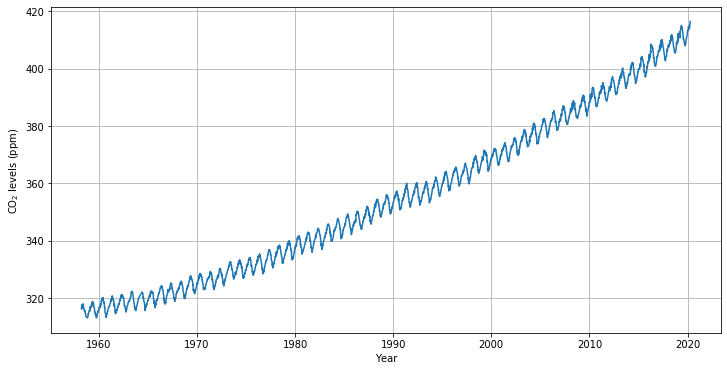

In [6]:
# Plot all of the data until now
fig = plt.figure(figsize=(12,6))
plt.plot(data.date, data.CO2)
plt.grid()
plt.xlabel("Year")
plt.ylabel(r'CO$_2$ levels (ppm)')
plt.show()

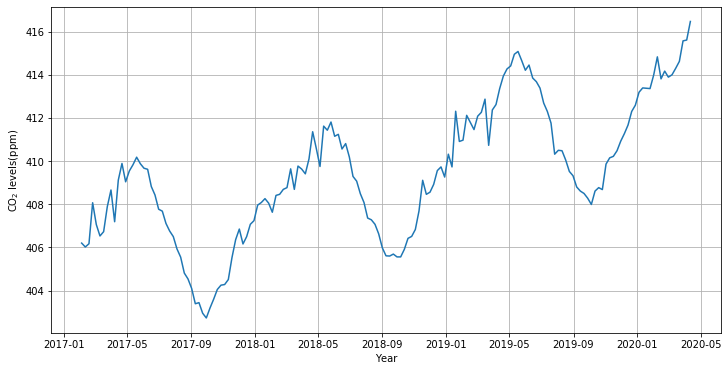

In [7]:
# Zoom in to see the rising pattern and random variations from 2017 to 2020
fig = plt.figure(figsize=(12, 6))
plt.plot(data.loc[3000:, ["date"]], data.loc[3000:, ["CO2"]])
plt.grid()
plt.xlabel("Year")
plt.ylabel(r'CO$_2$ levels(ppm)')
plt.show()

In [9]:
# Helper functions from class sessions

# Plot sample autocorrelation for each parameter.
def plot_acf(x):
    from scipy import signal
    plt.acorr(
        x, maxlags=20, detrend=lambda x: signal.detrend(x, type='constant'))

# Plot multiple ACF plots
def acf_plots(samples, parameters):
    for param in parameters:
        plt.figure(figsize=(10, 3))
        plot_acf(samples[param])
        plt.title(f"Autocorrelation plots for samples of {param}")
    plt.show()


# Make pair plot of the posteriors over all parameters of the model.
def pair_plots(samples, parameters):
    df = pd.DataFrame(
        data=np.transpose([samples[param] for param in parameters]),
        columns=parameters)
    sns.pairplot(df, height=3.5, plot_kws={'marker': '.', 'alpha': 0.25})
    plt.show()

## Select the training dataset (first 90% of the available data)

In [10]:
# Select 90% of the dataset to train, the rest to compare
test_idx = len(data.days) // 10 * 9

stan_train_data = {
    "N": len(range(test_idx)),
    "time": data.days[:test_idx],
    "CO2": data.CO2[:test_idx]
}

#Modelling the trend, seasonality, and noise

- For trend, I will try 2 different assumptions: linear and quadratic trend.
- For seasonality, I will assume the distribution follows a double-sine function.
- For noise, I assume it's gamma distributed with a small spread and average

## 1, Orignal Linear Model



In [11]:
linear_code = """
data {
    int<lower=1> N;         // Number of data points
    int<lower=0> time[N];   // Time array of days
    real<lower=0> CO2[N];   // CO2 measurements array
}

parameters {
    real<lower=0> c0;       // Intercept
    real<lower=0> c1;       // Slope
    real<lower=0> sigma;    // Noise

    // Amplitude
    real<lower=0> a;

    // Phase
    real<lower=0, upper=pi()> phi;
}

model {
    // Priors
    c0 ~ normal(310, 2);        // Infer from the mean the data
    c1 ~ cauchy(0, 1);          // Infer from the trajectory of the data
    sigma ~ normal(0, 1);       // So that sigma is positive and relatively small

    a ~ cauchy(0,1);
    phi ~ cauchy(0,1);

    //Likelihood
    for (i in 1:N) {
        CO2[i] ~ normal(c0 + c1*time[i] + a*cos((2*pi()/365.25)*time[i] + phi), sigma);
    }   
}
"""
linear_model = pystan.StanModel(model_code=linear_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_8f7429c37bd58c4ccae202457509e9d9 NOW.


In [12]:
# Train linear model
linear_results = linear_model.sampling(data=stan_train_data)
linear_results

Inference for Stan model: anon_model_8f7429c37bd58c4ccae202457509e9d9.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
c0    307.73  1.8e-3   0.12 307.49 307.65 307.73 307.81 307.96   4248    1.0
c1    4.1e-3  1.5e-710.0e-6 4.1e-3 4.1e-3 4.1e-3 4.1e-3 4.1e-3   4206    1.0
sigma   3.06  8.6e-4   0.04   2.98   3.03   3.06   3.09   3.14   2300    1.0
a       2.56  1.7e-3   0.08    2.4   2.51   2.56   2.62   2.72   2205    1.0
phi   2.2e-3  4.5e-5 2.3e-3 6.0e-5 6.1e-4 1.5e-3 3.1e-3 8.6e-3   2554    1.0
lp__   -4618    0.04   1.61  -4622  -4619  -4618  -4617  -4616   1521    1.0

Samples were drawn using NUTS at Mon Apr 27 13:02:00 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

In [13]:
# Record parameters and extract samples
linear_params = ["c0", "c1", "sigma", "a", "phi"]
linear_samples = linear_results.extract()

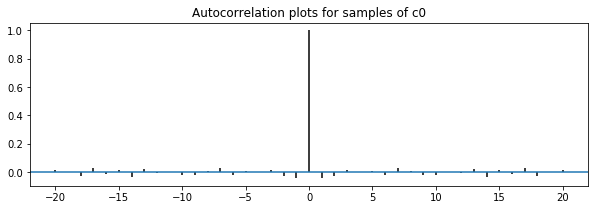

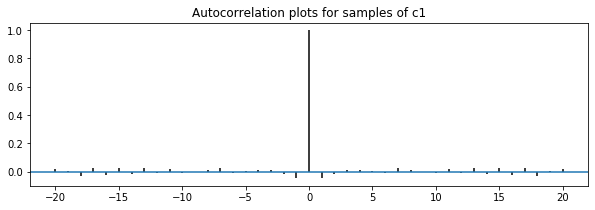

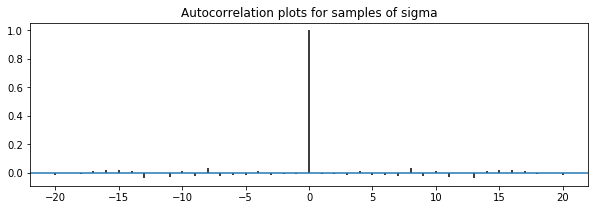

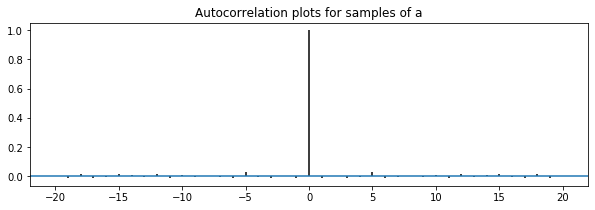

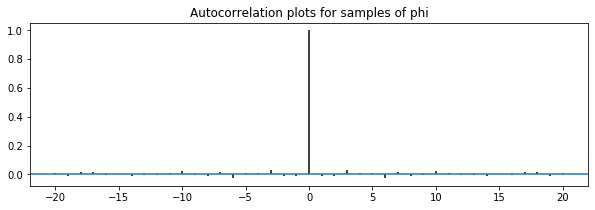

In [14]:
# Plot ACF for linear model
acf_plots(linear_samples, linear_params)

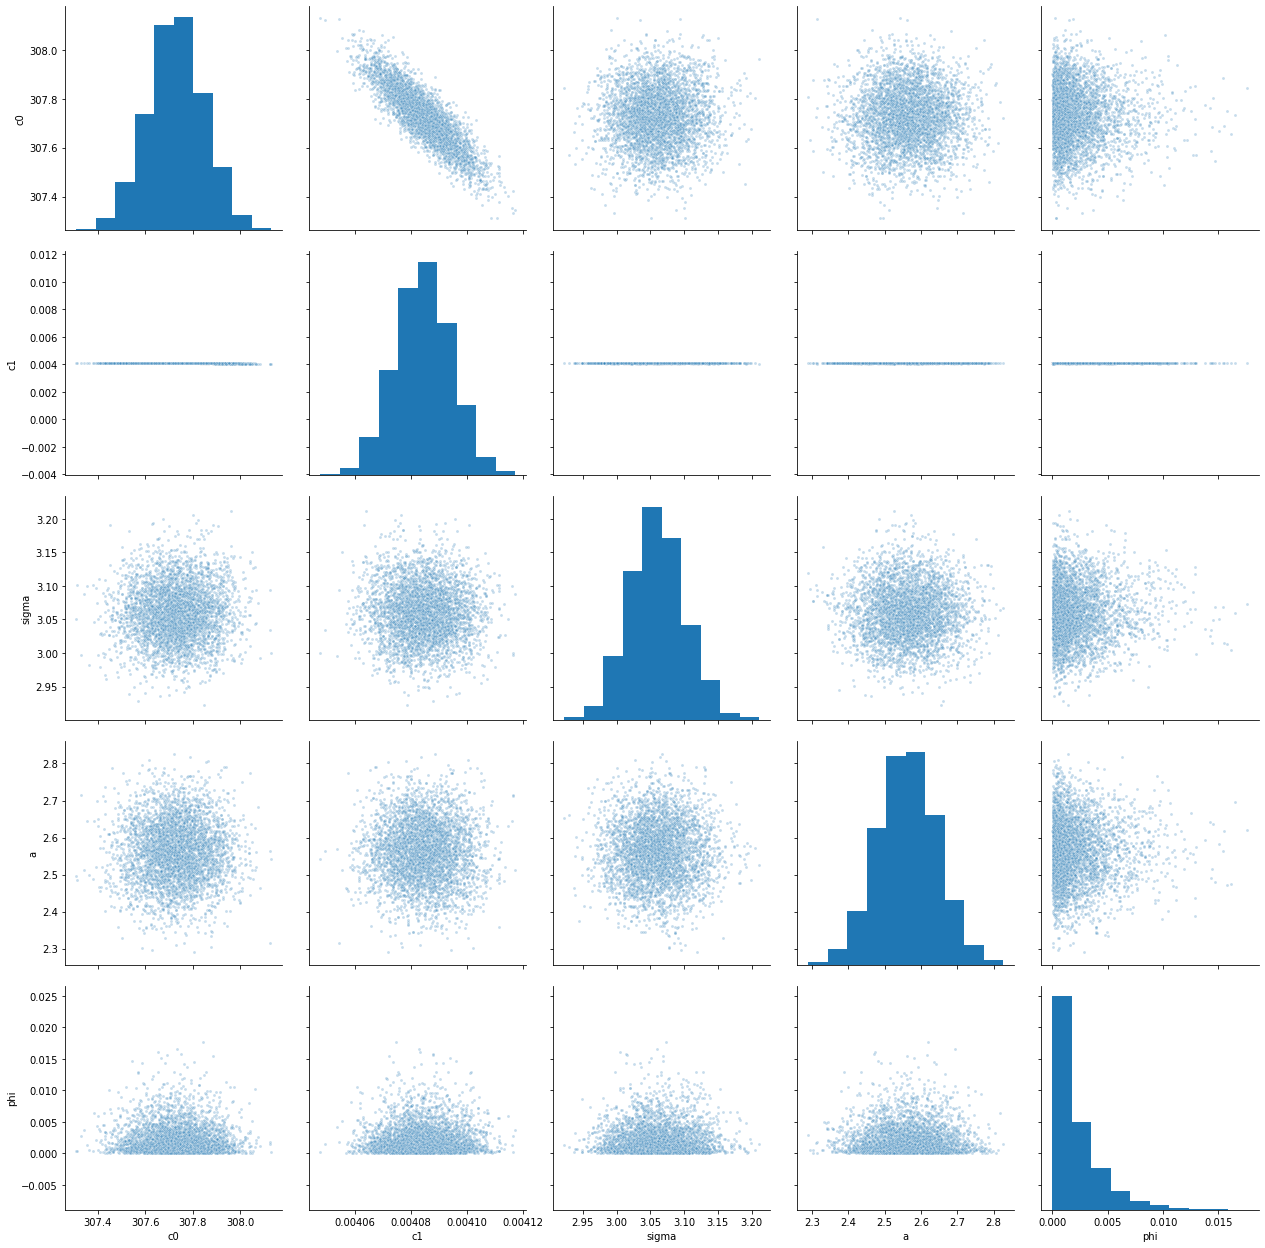

In [15]:
# Plot pair plots for linear params
pair_plots(linear_samples, linear_params)

## 2, Quadratic Model


In [16]:
quadratic_code = """
data {
    int<lower=0> N;
    int<lower=0> time[N];
    real<lower=0> CO2[N];
}

parameters {
    real<lower=0> c0;
    real<lower=0> c1;
    real<lower=0> c2;
    real<lower=0> sigma;

    // Amplitude
    real<lower=0> a;

    // Phase
    real<lower=0, upper=pi()> phi;
}

model {
    // Priors
    c0 ~ normal(315, 2);         // Infer from the actual intercept
    c1 ~ cauchy(0, 2);           // Kept relatively small but broad because the model is quadratic
    c2 ~ cauchy(0, 2);           // Kept relatively small but broad because the model is quadratic
    sigma ~ normal(2, 1);        // So that sigma is positive and relatively small

    a ~ cauchy(0, 1);
    phi ~ cauchy(0, 1);

    // Likelihood
    for (i in 1:N) {
        CO2[i] ~ normal(c0 + c1*time[i] + c2*(time[i]^2) + a*cos((2*pi()/365.25) * time[i] + phi), sigma);
    } 
}
"""
quadratic_model = pystan.StanModel(model_code=quadratic_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_a63e1428a4b536eee028a65a8a362060 NOW.


In [17]:
# Train quadratic model
quad_results = quadratic_model.sampling(data=stan_train_data)
quad_results

Inference for Stan model: anon_model_a63e1428a4b536eee028a65a8a362060.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
c0    314.29  2.1e-3   0.07 314.15 314.24 314.29 314.34 314.43   1244    1.0
c1    2.2e-3  5.3e-7 1.6e-5 2.2e-3 2.2e-3 2.2e-3 2.2e-3 2.2e-3    947    1.0
c2    9.1e-8 2.5e-117.7e-10 9.0e-8 9.1e-8 9.1e-8 9.2e-8 9.3e-8    957    1.0
sigma   1.25  3.0e-4   0.02   1.21   1.23   1.25   1.26   1.28   2903    1.0
a       2.59  6.4e-4   0.03   2.52   2.56   2.59   2.61   2.65   2864    1.0
phi   3.5e-4  6.4e-6 3.4e-4 7.0e-6 1.0e-4 2.6e-4 4.8e-4 1.3e-3   2900    1.0
lp__   -2071    0.05   1.78  -2076  -2072  -2071  -2070  -2069   1233    1.0

Samples were drawn using NUTS at Mon Apr 27 13:08:18 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains

In [18]:
# Record parameters and extract samples
quad_params = ["c0", "c1", "c2", "sigma", "a", "phi"]
quad_samples = quad_results.extract()

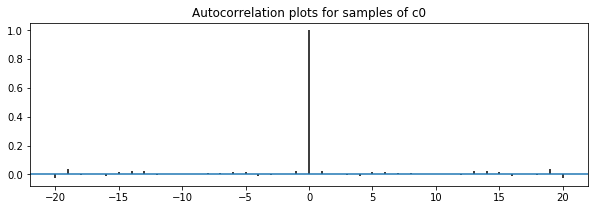

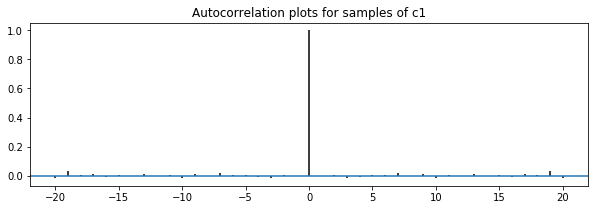

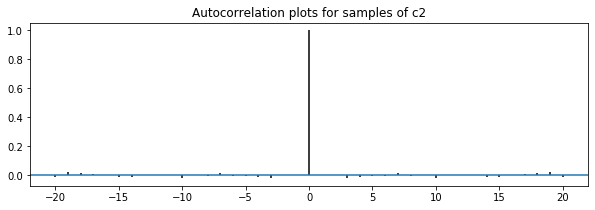

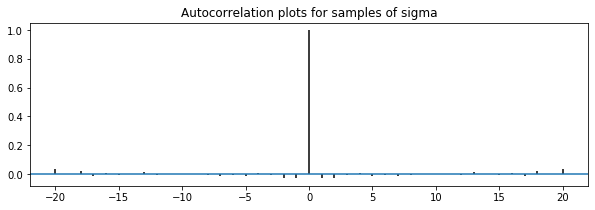

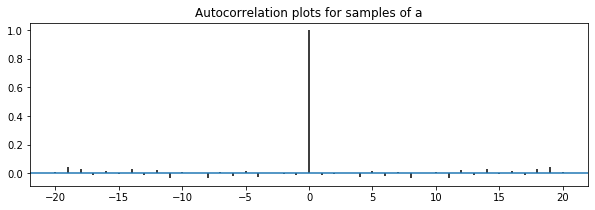

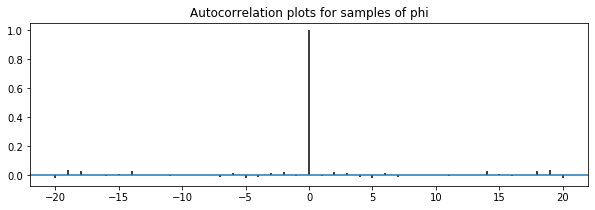

In [19]:
# ACF plots for quadratic model
acf_plots(quad_samples, quad_params)

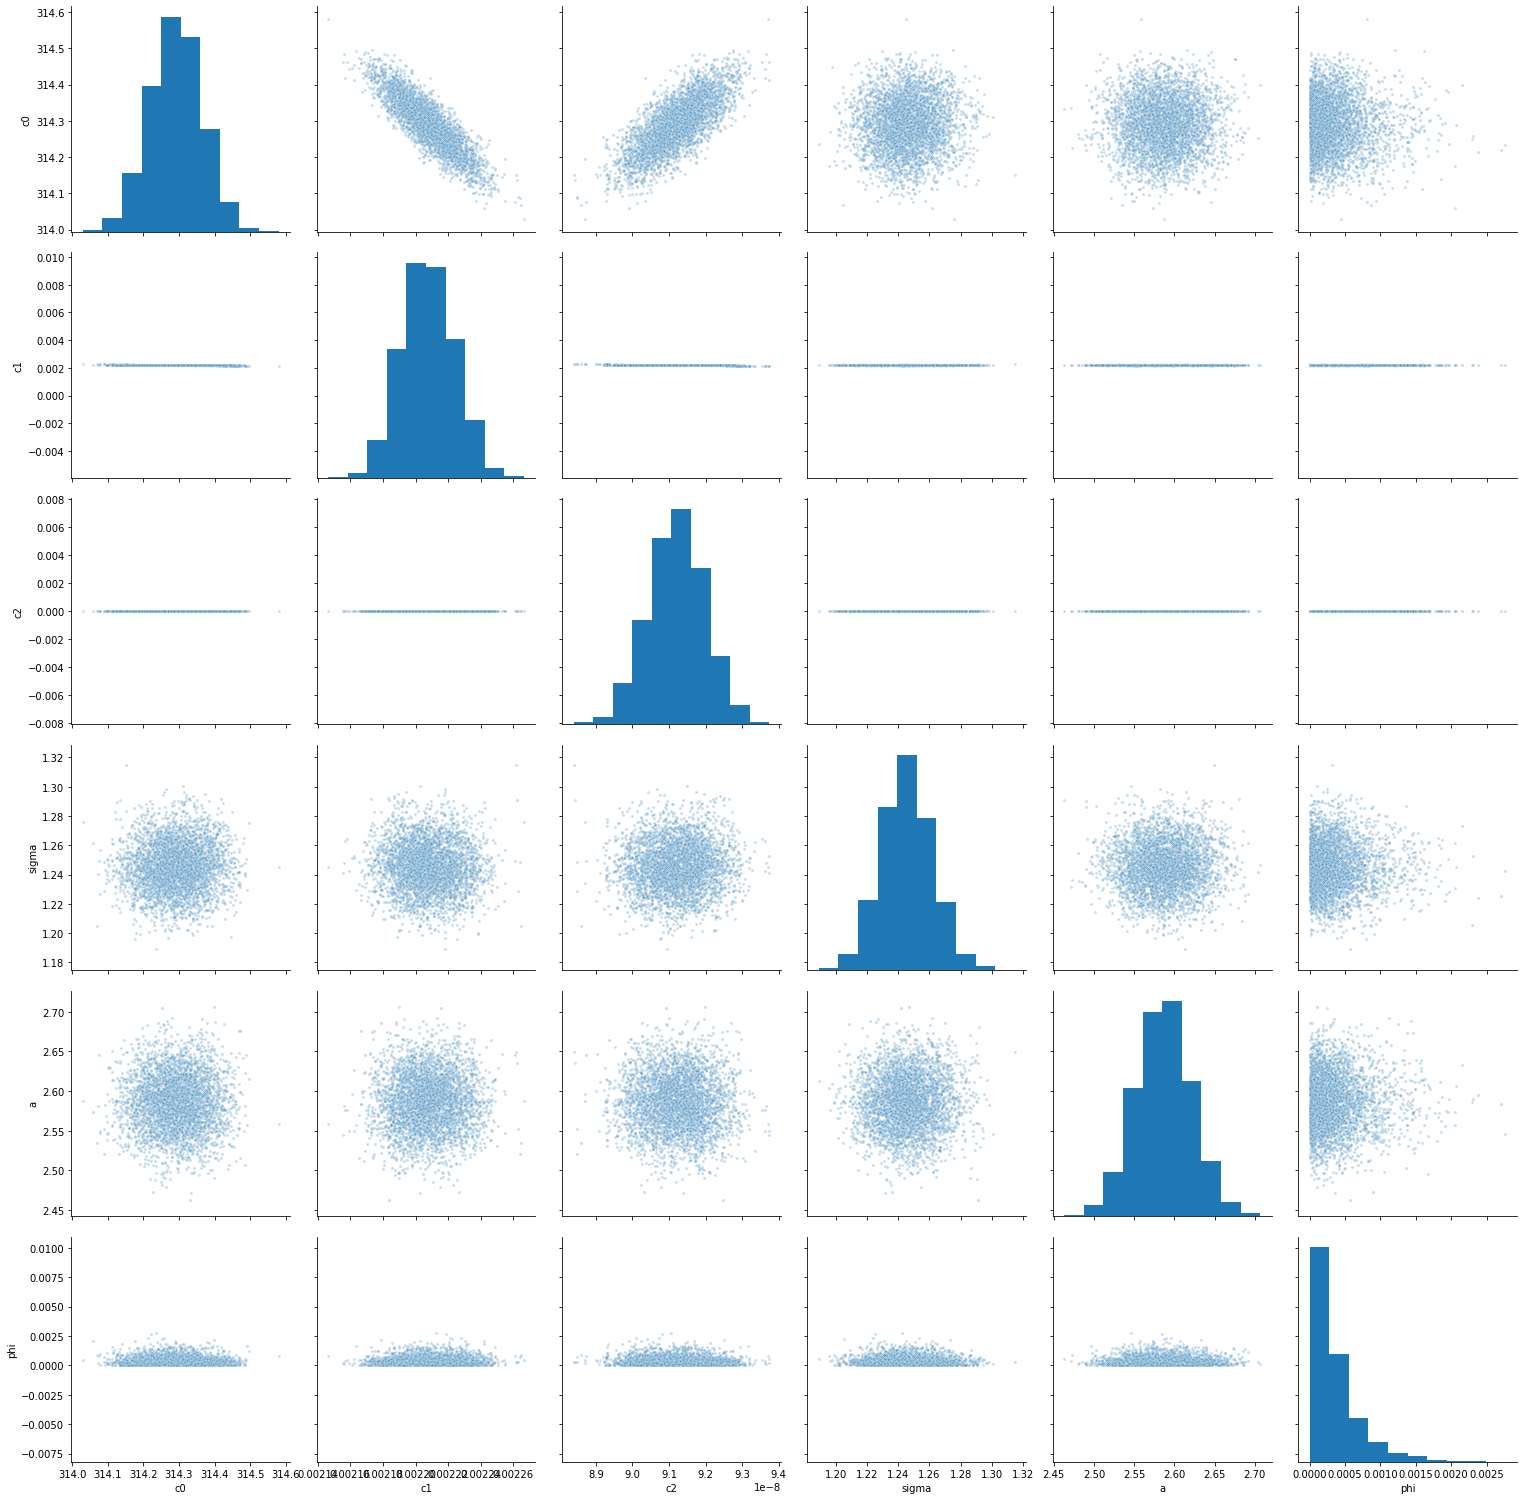

In [20]:
# Pair plots for quadratic model
pair_plots(quad_samples, quad_params)

## 3, Quadratic model with custom cos function

In [21]:
quadratic_cos_code = """
data {
    int<lower=0> N;
    int<lower=0> time[N];
    real<lower=0> CO2[N];
}

parameters {
    real<lower=0> c0;     // Intercept
    real<lower=0> c1;     // Coefficient
    real<lower=0> c2;     // Coefficient
    real<lower=0> sigma;  // Noise

    // Amplitudes
    real<lower=0> a1;
    real<lower=0> a2;

    // Phase
    real<lower=0, upper=pi()/2> phi;
}

model {
    // Priors
    c0 ~ normal(315, 2);       // Infer from the actual intercept
    c1 ~ cauchy(0, 2);         // Kept relatively small but broad because the model is quadratic
    c2 ~ cauchy(0, 2);         // Kept relatively small but broad because the model is quadratic
    sigma ~ normal(2, 1);      // So that sigma is positive and relatively small

    a1 ~ cauchy(0, 1);
    a2 ~ cauchy(0, 1);
    phi ~ cauchy(0, 1);

    // Likelihood
    for (i in 1:N) {
        CO2[i] ~ normal(c0 + c1*time[i] + c2*(time[i]^2) + a1*cos((2*pi()/365.25) * time[i] + phi) + a2*cos((2*2*pi()/365.25) * time[i] + phi), sigma);
    } 
}
"""
quadratic_cos_model = pystan.StanModel(model_code=quadratic_cos_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_fa21611ee4f8d0d60ee6dbbf0d51ccbc NOW.


In [22]:
# Train new quadratic model
quad_cos_results = quadratic_cos_model.sampling(data=stan_train_data)
quad_cos_results

# https://mc-stan.org/misc/warnings.html#maximum-treedepth-exceeded
# Maximum treedepth warnings is not a validity issue, its an efficiency issue. The samples here are good, so I'll go with it

Inference for Stan model: anon_model_fa21611ee4f8d0d60ee6dbbf0d51ccbc.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
c0    314.29  1.6e-3   0.07 314.15 314.25 314.29 314.34 314.43   1834    1.0
c1    2.2e-3  4.1e-7 1.6e-5 2.2e-3 2.2e-3 2.2e-3 2.2e-3 2.2e-3   1455    1.0
c2    9.1e-8 2.0e-117.5e-10 9.0e-8 9.1e-8 9.1e-8 9.2e-8 9.3e-8   1472    1.0
sigma   1.25  2.6e-4   0.02   1.21   1.24   1.25   1.26   1.28   4267    1.0
a1      2.59  8.4e-4   0.03   2.52   2.56   2.59   2.61   2.65   1566    1.0
a2    1.5e-3  5.4e-5 1.6e-3 3.7e-5 4.0e-4 1.1e-3 2.1e-3 5.9e-3    871    1.0
phi   3.5e-4  1.0e-5 3.6e-4 1.1e-5 1.1e-4 2.4e-4 4.8e-4 1.4e-3   1218    1.0
lp__   -2079    0.06   1.91  -2084  -2080  -2079  -2078  -2077   1072    1.0

Samples were drawn using NUTS at Mon Apr 27 13:32:09 2020.
For each parameter, n_eff is a crude measure of effective 

In [23]:
# Record parameters and extract samples
quad_cos_params = ["c0", "c1", "sigma", "a1", "a2", "phi"]
quad_cos_samples = quad_cos_results.extract()

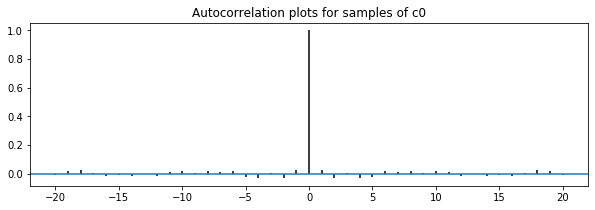

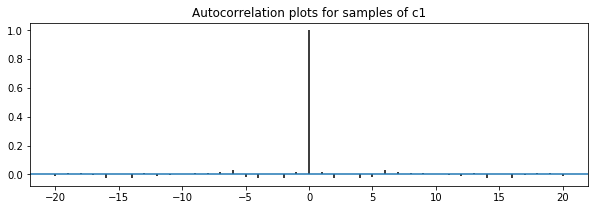

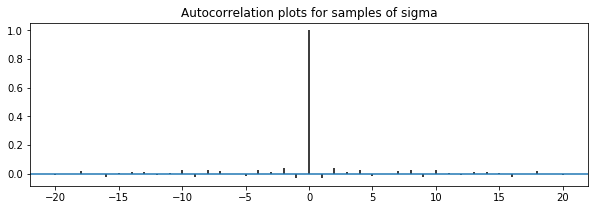

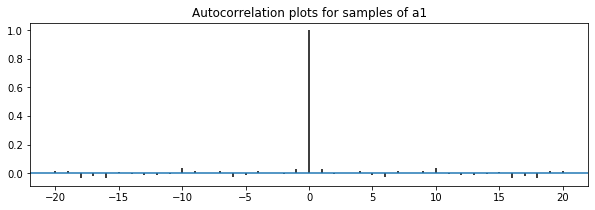

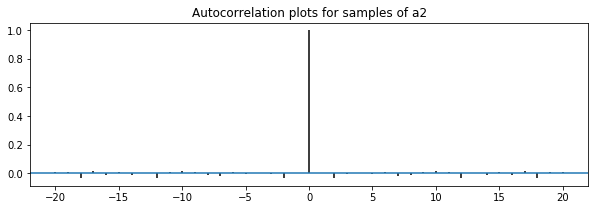

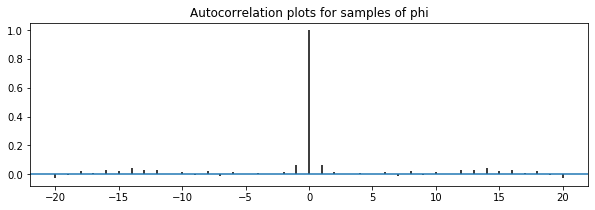

In [24]:
# ACF plots for new quadratic model
acf_plots(quad_cos_samples, quad_cos_params)

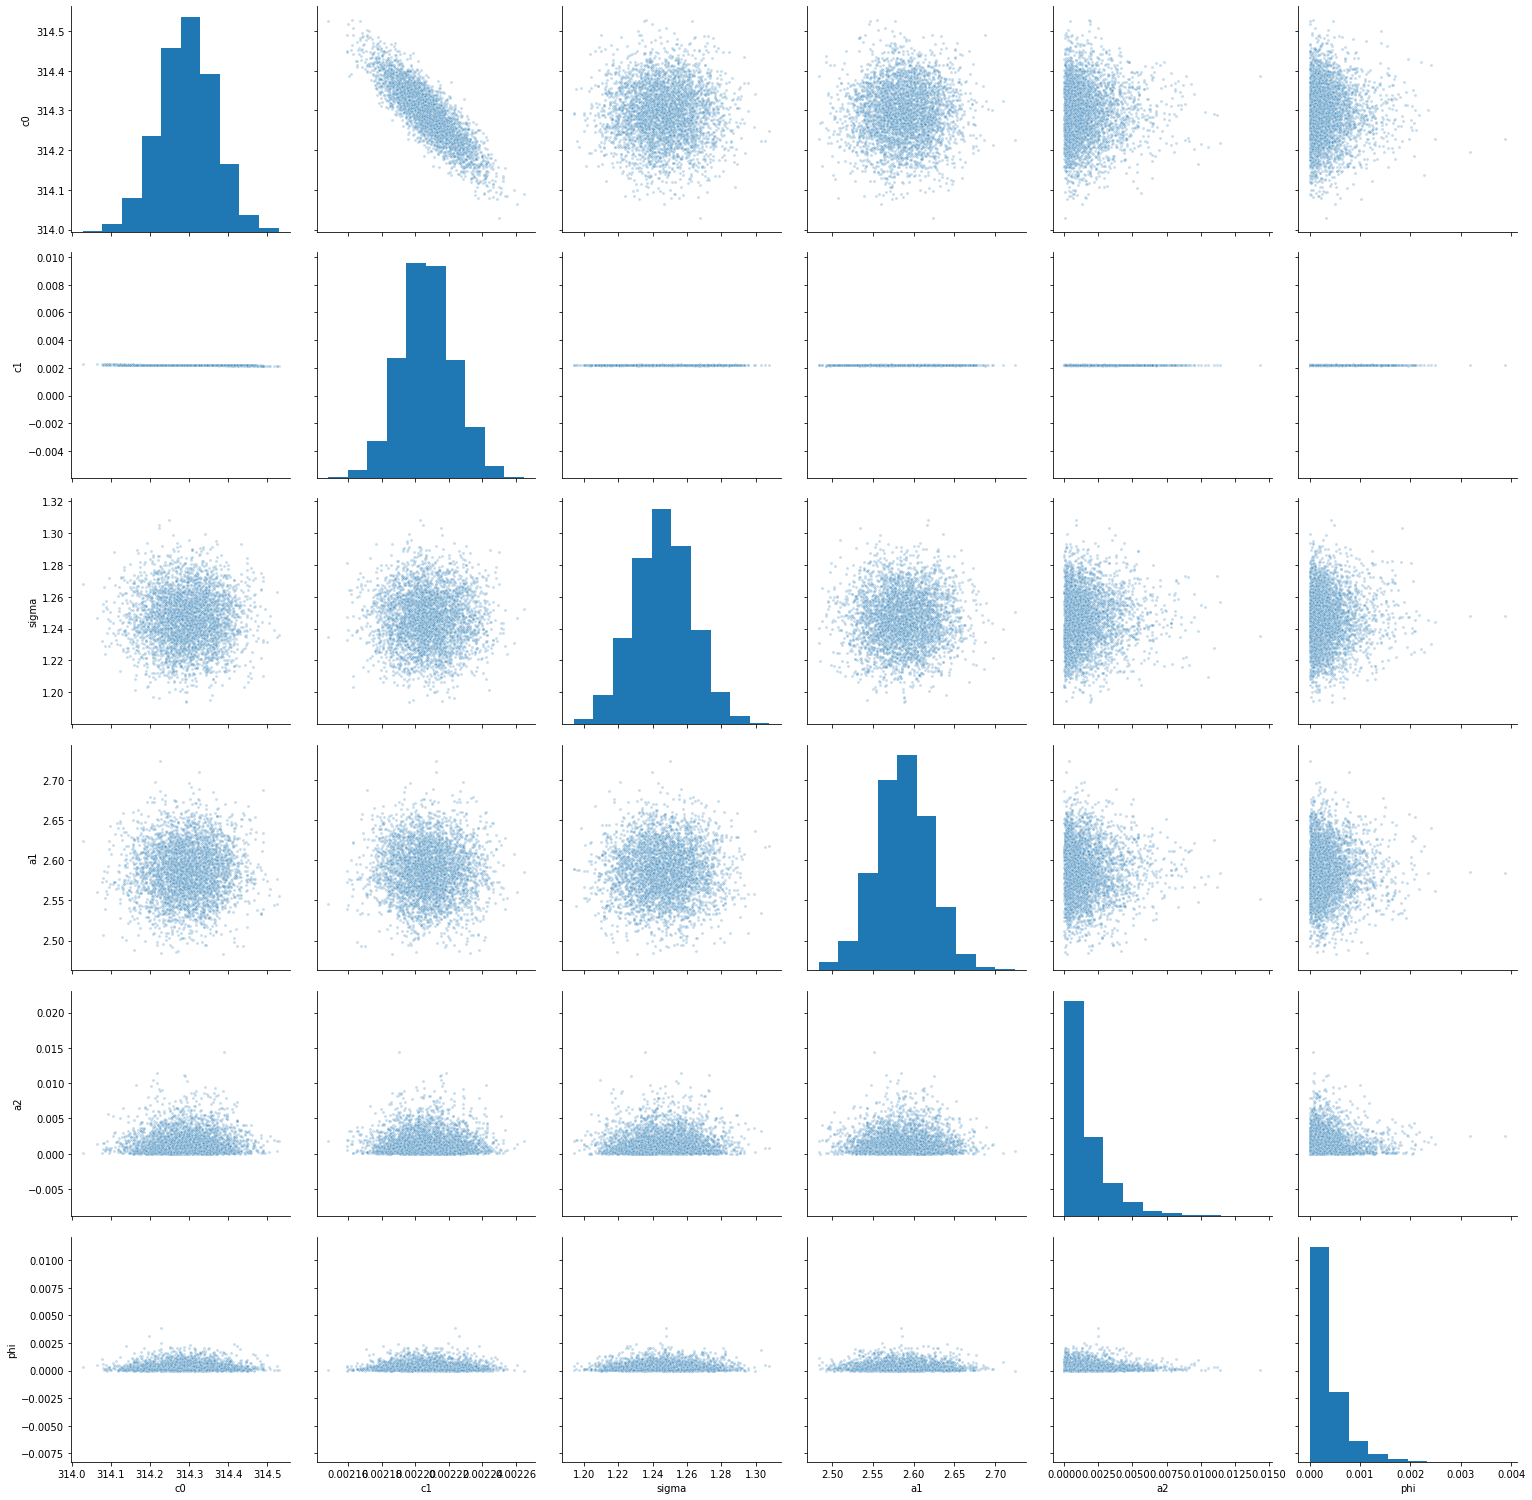

In [25]:
# Pair plots for new quadratic models
pair_plots(quad_cos_samples, quad_cos_params)

In [79]:
# Functions to generate predictions using the mean of posterier parameters' samples.
def generate_data_linear(time, linear_samples, size=1, mean=False):
    samples = sts.norm(linear_samples["c0"].mean() + linear_samples["c1"].mean()*time + 
                linear_samples["a"].mean() * np.cos(2*np.pi/365.25 * time + linear_samples["phi"].mean()), linear_samples["sigma"].mean()).rvs(size=size)
    return np.average(samples) if mean else samples

def generate_data_quad(time, quad_samples, size=1, mean=False):
    samples = sts.norm(quad_samples["c0"].mean() + quad_samples["c1"].mean()*time + quad_samples["c2"].mean()*(time**2) + 
                quad_samples["a"].mean() * np.cos(2*np.pi/365.25 * time + quad_samples["phi"].mean()), quad_samples["sigma"].mean()).rvs(size=size)
    return np.average(samples) if mean else samples

def generate_data_quad_cos(time, quad_cos_samples, size=1, mean=False):
    samples = sts.norm(quad_cos_samples["c0"].mean() + quad_cos_samples["c1"].mean()*time + quad_cos_samples["c2"].mean()*(time**2) + 
                quad_cos_samples["a1"].mean() * np.cos(2*np.pi/365.25 * time + quad_cos_samples["phi"].mean()) + 
                quad_cos_samples["a2"].mean() * np.cos(2*2*np.pi/365.25 * time + quad_cos_samples["phi"].mean()), quad_cos_samples["sigma"].mean()).rvs(size=size)
    return np.average(samples) if mean else samples

## What the predictions look like for the training dataset (the first 90% of the data)

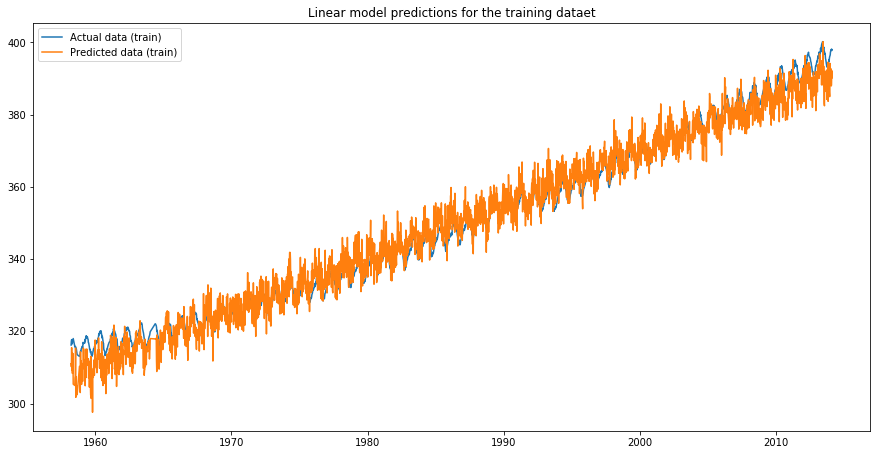

In [74]:
# Linear model
linear_train_data = []
for day in data.days.values[:test_idx]:
    linear_train_data.append(generate_data_linear(day, linear_samples, 1))

plt.figure(figsize=(15, 7.5))
plt.plot(data.date[:test_idx], data.CO2[:test_idx], label="Actual data (train)")
plt.plot(data.date[:test_idx], linear_train_data, label="Predicted data (train)")
plt.legend()
plt.title("Linear model predictions for the training dataet")
plt.show()

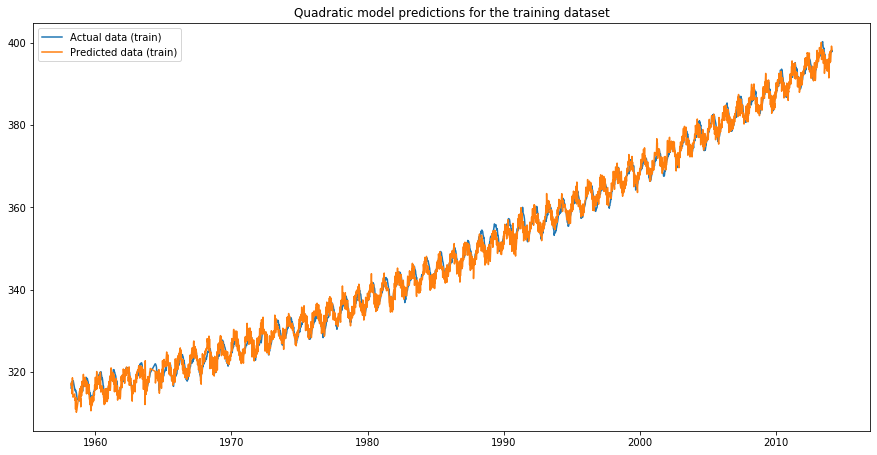

In [28]:
# Quadratic model
quad_train_data = []
for day in data.days.values[:test_idx]:
    quad_train_data.append(generate_data_quad(day, quad_samples, 1))


plt.figure(figsize=(15, 7.5))
plt.plot(data.date[:test_idx], data.CO2[:test_idx], label="Actual data (train)")
plt.plot(data.date[:test_idx], quad_train_data, label="Predicted data (train)")
plt.legend()
plt.title("Quadratic model predictions for the training dataset")
plt.show()

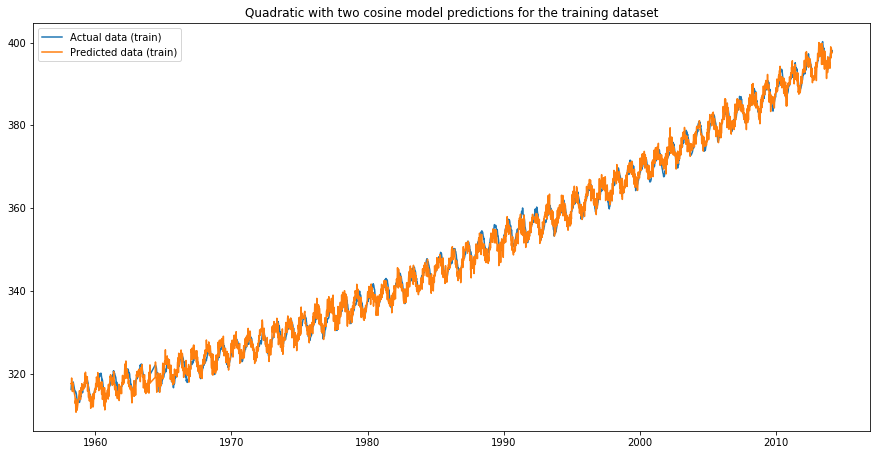

In [29]:
# Quadratic custom model
quad_cos_train_data = []
for day in data.days.values[:test_idx]:
    quad_cos_train_data.append(generate_data_quad_cos(day, quad_cos_samples, 1))


plt.figure(figsize=(15, 7.5))
plt.plot(data.date[:test_idx], data.CO2[:test_idx], label="Actual data (train)")
plt.plot(data.date[:test_idx], quad_cos_train_data, label="Predicted data (train)")
plt.legend()
plt.title("Quadratic with two cosine model predictions for the training dataset")
plt.show()

## What the predictions look like for the test dataset (the last 10% of the data)

In [30]:
# Helper function to calculate RMSE of predicted data
def rmse(predicted, actual):
    return np.sqrt(np.mean((predicted-actual)**2))

In [31]:
# Function to generate a histogram of sampled RMSE
def generate_rmse_dist(data_func, data_sample, model_name):
    result = []
    for i in range(500):
        sample = []
        for day in data.days[test_idx:]:
            sample.append(data_func(day, data_sample,  1))
        result.append(rmse(np.array(sample).flatten(), data.CO2[test_idx:]))

    
    plt.figure(figsize=(12, 6))
    plt.hist(result)
    plt.title(f"Distribution of RMSE for {model_name}, mean={round(np.mean(result), 2)}")
    plt.show()

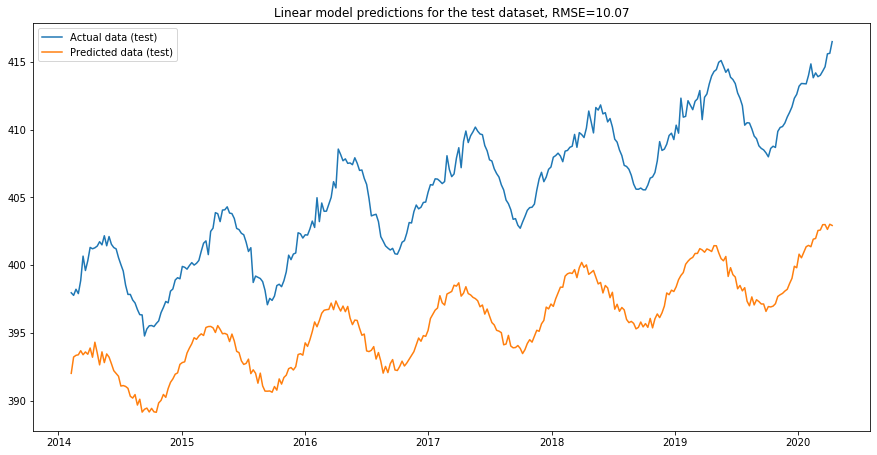

In [75]:
# Linear model
linear_test_data = []

for day in data.days.values[test_idx:]:
    linear_test_data.append(generate_data_linear(day, linear_samples, 100, mean=True))

linear_rmse = round(rmse(np.array(linear_test_data).flatten(), data.CO2[test_idx:]), 2)

plt.figure(figsize=(15, 7.5))
plt.plot(data.date[test_idx:], data.CO2[test_idx:], label="Actual data (test)")
plt.plot(data.date[test_idx:], linear_test_data, label="Predicted data (test)")
plt.legend()
plt.title(f"Linear model predictions for the test dataset, RMSE={linear_rmse}")
plt.show()

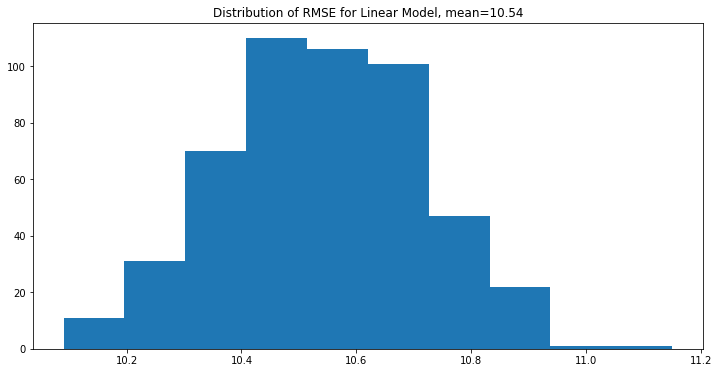

In [33]:
generate_rmse_dist(generate_data_linear, linear_samples, "Linear Model")

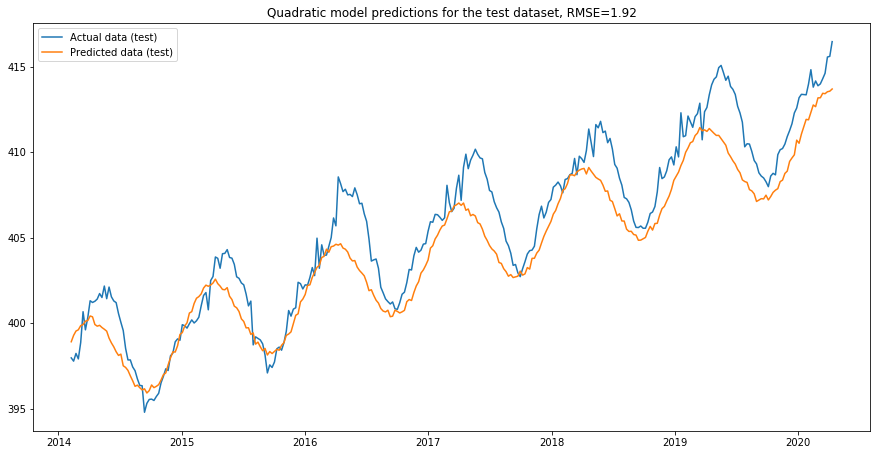

In [80]:
# Quadratic model
quad_test_data = []
for day in data.days.values[test_idx:]:
    quad_test_data.append(generate_data_quad(day, quad_samples, 100, mean=True))

quad_rmse = round(rmse(np.array(quad_test_data).flatten(), data.CO2[test_idx:]), 2)

plt.figure(figsize=(15, 7.5))
plt.plot(data.date[test_idx:], data.CO2[test_idx:], label="Actual data (test)")
plt.plot(data.date[test_idx:], quad_test_data, label="Predicted data (test)")
plt.legend()
plt.title(f"Quadratic model predictions for the test dataset, RMSE={quad_rmse}")
plt.show()

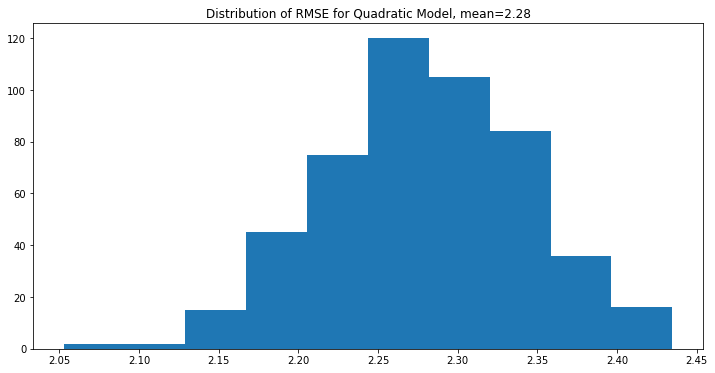

In [35]:
generate_rmse_dist(generate_data_quad, quad_samples, "Quadratic Model")

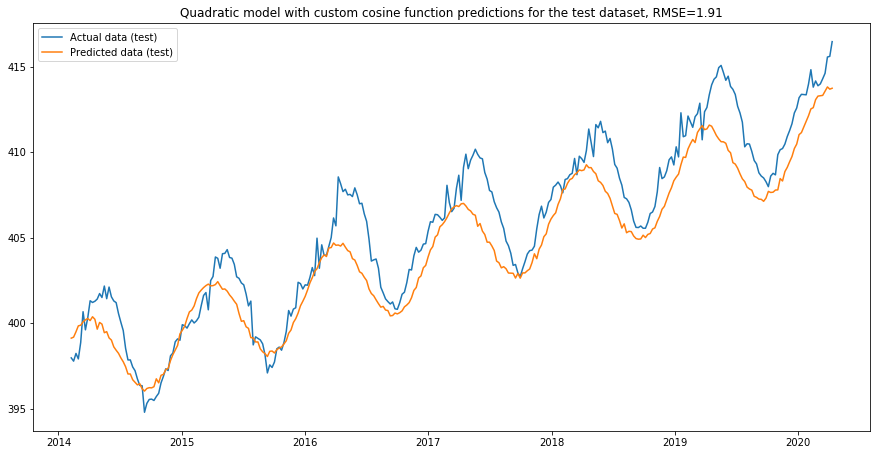

In [83]:
# Quadratic model with custom cosine function
quad_cos_test_data = []
for day in data.days.values[test_idx:]:
    quad_cos_test_data.append(generate_data_quad_cos(day, quad_cos_samples, 100, mean=True))

quad_rmse = round(rmse(np.array(quad_cos_test_data).flatten(), data.CO2[test_idx:]), 2)

plt.figure(figsize=(15, 7.5))
plt.plot(data.date[test_idx:], data.CO2[test_idx:], label="Actual data (test)")
plt.plot(data.date[test_idx:], quad_cos_test_data, label="Predicted data (test)")
plt.legend()
plt.title(f"Quadratic model with custom cosine function predictions for the test dataset, RMSE={quad_rmse}")
plt.show()

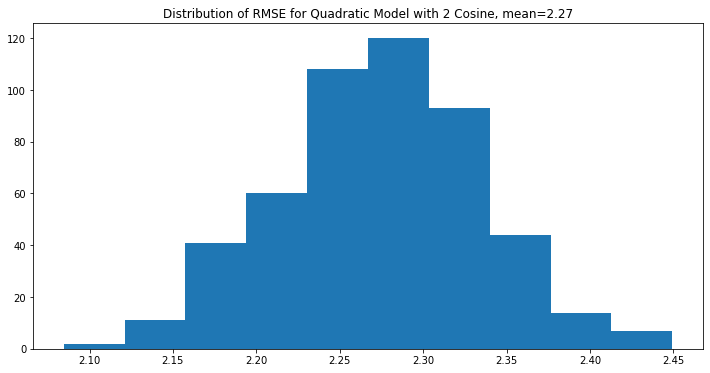

In [37]:
generate_rmse_dist(generate_data_quad_cos, quad_cos_samples, "Quadratic Model with 2 Cosine")

## Future predictions with the best model: **quadratic model with one cosine function**

In [38]:
# Select full dataset
stan_full_data = {
    "N": len(data.days),
    "time": data.days,
    "CO2": data.CO2
}

In [39]:
# Retrain the model with all of the data
final_results = quadratic_model.sampling(data=stan_full_data)

In [40]:
# Show full results
final_results

Inference for Stan model: anon_model_a63e1428a4b536eee028a65a8a362060.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
c0     314.6  1.5e-3   0.07 314.47 314.56  314.6 314.65 314.74   2171    1.0
c1    2.1e-3  3.4e-7 1.4e-5 2.1e-3 2.1e-3 2.1e-3 2.1e-3 2.1e-3   1735    1.0
c2    9.8e-8 1.4e-115.9e-10 9.6e-8 9.7e-8 9.8e-8 9.8e-8 9.9e-8   1759    1.0
sigma   1.28  3.0e-4   0.02   1.25   1.27   1.28   1.29   1.31   3099    1.0
a       2.62  6.2e-4   0.03   2.56    2.6   2.62   2.64   2.68   2687    1.0
phi   3.5e-4  6.6e-6 3.4e-4 1.0e-5 1.0e-4 2.4e-4 4.7e-4 1.2e-3   2638    1.0
lp__   -2387    0.04   1.77  -2391  -2388  -2386  -2385  -2384   1601    1.0

Samples were drawn using NUTS at Mon Apr 27 13:42:43 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains

In [41]:
# Record parameters and extract samples
quad_params = ["c0", "c1", "c2", "sigma", "a", "phi"]
final_samples = final_results.extract()

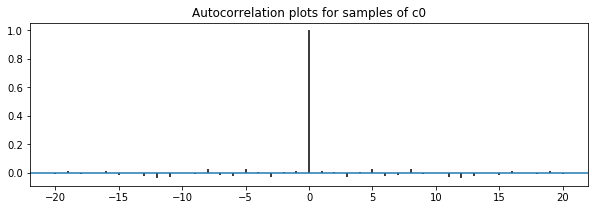

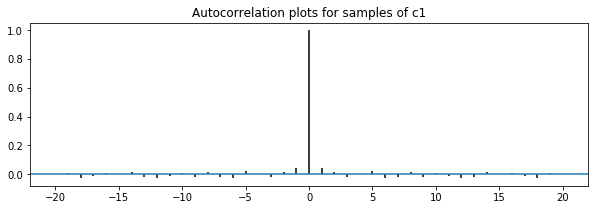

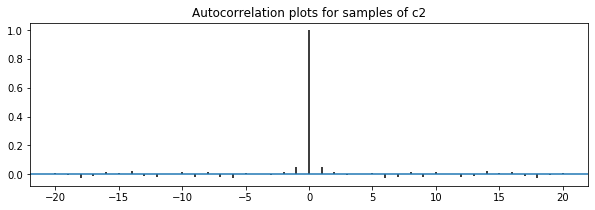

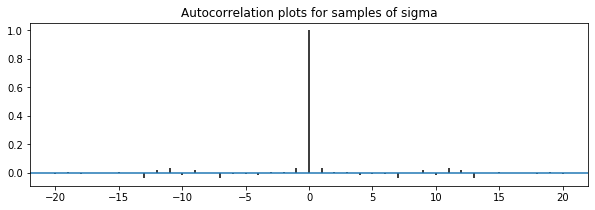

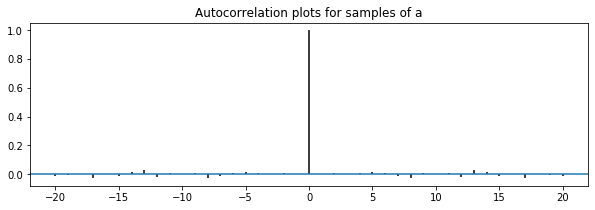

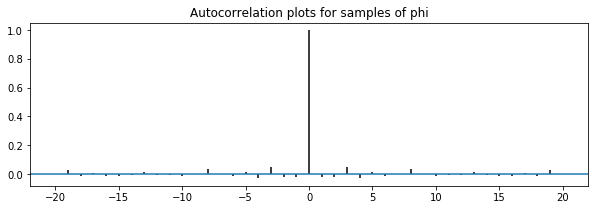

In [42]:
acf_plots(final_samples, quad_params)

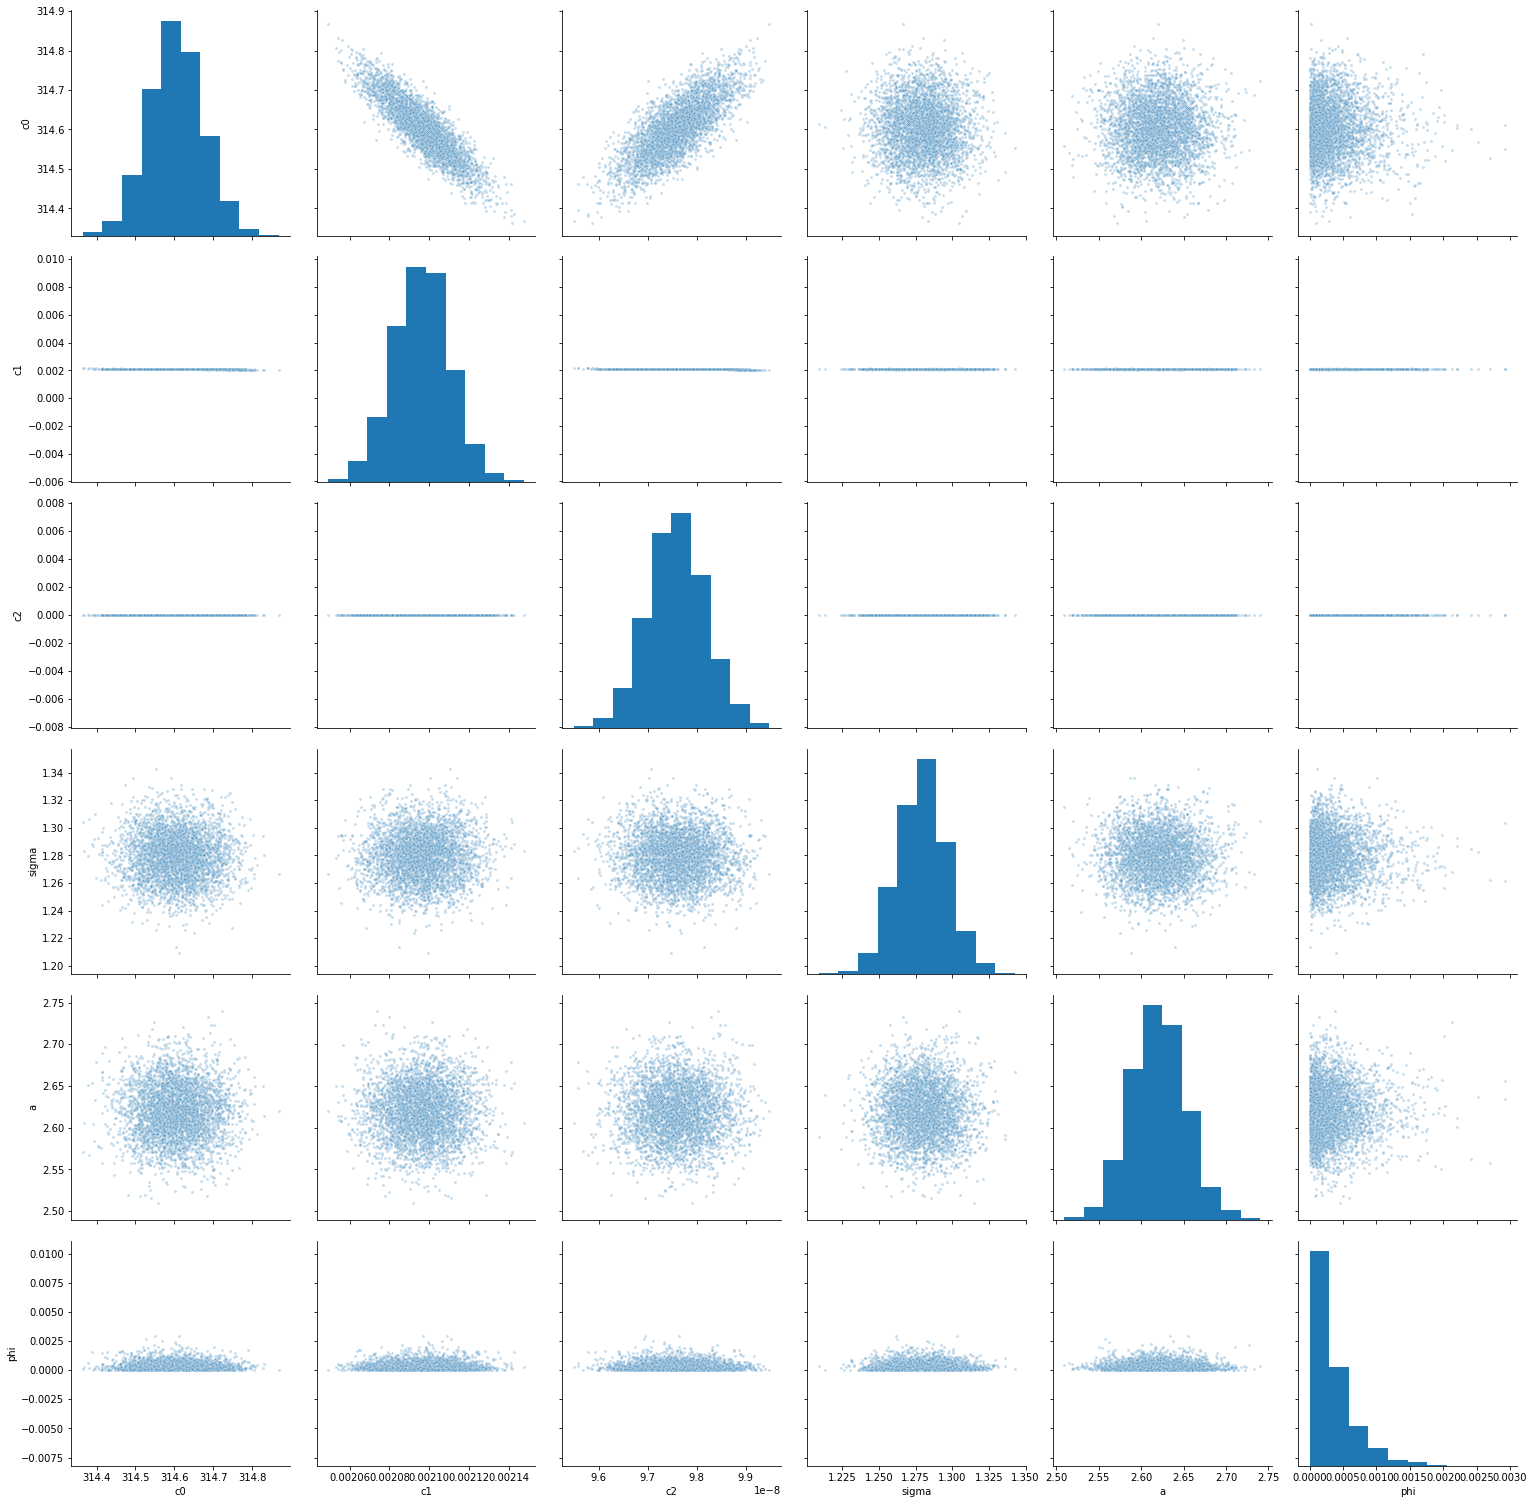

In [43]:
pair_plots(final_samples, quad_params)

In [44]:
## Future prediction setup
prediction_dates = pd.date_range("2020-04-11", "2060-01-01", freq='W-FRI')
prediction_days = (prediction_dates - data.date.values[0]).days

In [84]:
pred_mean = []      # Mean
pred_lower = []     # Lower 2.5%
pred_upper = []     # Upper 97.5%

# For every day we want to predict the future, generate 500 samples and calculate the mean and percentiles
for day in prediction_days:
    samples = generate_data_quad(day, final_samples, 500)
    percentiles = np.percentile(samples, [2.5, 97.5])
    pred_mean.append(np.mean(samples))
    pred_lower.append(percentiles[0])
    pred_upper.append(percentiles[1])    

## Graph showing predictions and danger line

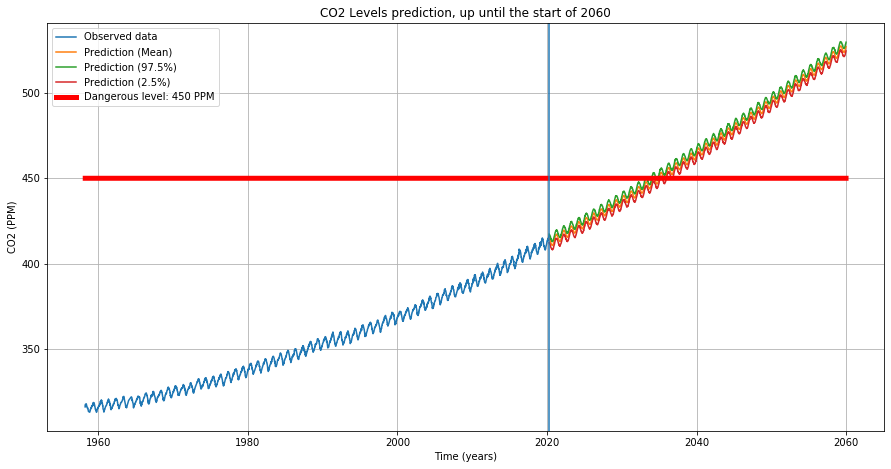

In [46]:
total_range = pd.date_range("1958-03-29", "2060-01-01", freq='W-FRI')
plt.figure(figsize=(15, 7.5))
plt.grid()
plt.plot(data.date, data.CO2, label="Observed data")
plt.plot(prediction_dates, pred_mean, label="Prediction (Mean)")
plt.plot(prediction_dates, pred_upper, label="Prediction (97.5%)")
plt.plot(prediction_dates, pred_lower, label="Prediction (2.5%)")
plt.plot(total_range, [450]*len(total_range), c="r", linewidth=5, label="Dangerous level: 450 PPM")
plt.legend()
plt.title("CO2 Levels prediction, up until the start of 2060")
plt.axvline(prediction_dates[0])
plt.xlabel("Time (years)")
plt.ylabel("CO2 (PPM)")
plt.show()

## Zoomed in version

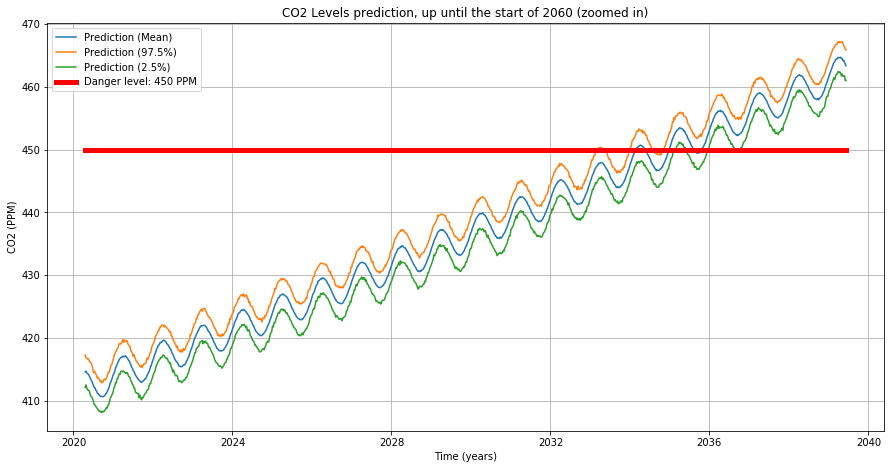

In [47]:
plt.figure(figsize=(15, 7.5))
plt.grid()
plt.plot(prediction_dates[:1000], pred_mean[:1000], label="Prediction (Mean)")
plt.plot(prediction_dates[:1000], pred_upper[:1000], label="Prediction (97.5%)")
plt.plot(prediction_dates[:1000], pred_lower[:1000], label="Prediction (2.5%)")
plt.plot(prediction_dates[:1000], [450]*(len(prediction_dates) - 1072), c="r", linewidth=5, label="Danger level: 450 PPM")
plt.legend()
plt.title("CO2 Levels prediction, up until the start of 2060 (zoomed in)")
plt.xlabel("Time (years)")
plt.ylabel("CO2 (PPM)")
plt.show()

In [48]:
# Put predictions in a dataframe
pred_df = pd.DataFrame(data={
    "dates": prediction_dates,
    "pred_mean": pred_mean,
    "pred_upper": pred_upper,
    "pred_lower": pred_lower
})
pred_df.head()

,dates,pred_mean,pred_upper,pred_lower
0,2020-04-17,414.647399,417.292096,412.196252
1,2020-04-24,414.738370,416.947801,412.565086
2,2020-05-01,414.556196,416.898255,412.112870
3,2020-05-08,414.339003,416.675191,411.837577
4,2020-05-15,414.296205,416.740092,411.688589


In [158]:
# Extract dates when CO2 levels will reach 450 PPM

danger_mean = pred_df["dates"][pred_df["pred_mean"] >= 450].values[0]
danger_upper = pred_df["dates"][pred_df["pred_upper"] >= 450].values[0]
danger_lower = pred_df["dates"][pred_df["pred_lower"] >= 450].values[0]

print(f"Most likely, CO2 will reach the 450 PPM mark at around {danger_mean}")
print(f"Best case, CO2 will reach the 450 PPM mark at around {danger_lower}")
print(f"Worst case, CO2 will reach the 450 PPM mark at around {danger_upper}")

Most likely, CO2 will reach the 450 PPM mark at around 2034-03-03T00:00:00.000000000
Best case, CO2 will reach the 450 PPM mark at around 2035-02-23T00:00:00.000000000
Worst case, CO2 will reach the 450 PPM mark at around 2033-03-11T00:00:00.000000000


# Posterior Predictive Checks

For the quadratic model

In [162]:
# Helper function to generate test statistics for a particular model
def generate_test_statistics(test_func, data_func, model_samples):
    result = []
    for i in range(200):
        sample = []
        for day in data.days.values:
            sample.append(data_func(day, model_samples, 1))
        result.append(test_func(sample))
    return result


# Helper function to generate a histogram based on sampled and actual test statistics
def generate_test_histogram(test_samples, actual_statistic, statistic_name):
    plt.figure(figsize=(5, 5))
    plt.hist(test_samples, density=True, alpha=0.5)
    plt.axvline(actual_statistic, linewidth=5)

    p_value = round(np.mean(actual_statistic > test_samples), 2)

    plt.title(f"Histogram of sampled statistic for {statistic_name}. P-value: {p_value}")


# Custom test statstic: upper 97.5% percentile
def percentile_high(sample):
    return np.percentile(sample, [2.5, 97.5])[1]


# Custom test statstic: lower 2.5% percentile
def percentile_low(sample):
    return np.percentile(sample, [2.5, 97.5])[0]

In [51]:
test_mean = generate_test_statistics(np.mean, generate_data_quad, final_samples)

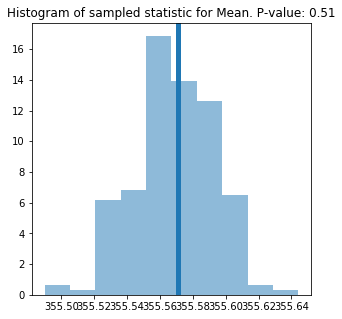

In [163]:
generate_test_histogram(test_mean, np.mean(data.CO2.values), "Mean")

In [53]:
test_std = generate_test_statistics(np.std, generate_data_quad, final_samples)

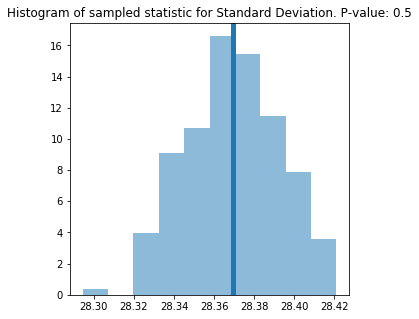

In [164]:
generate_test_histogram(test_std, np.std(data.CO2.values), "Standard Deviation")

In [150]:
test_percentile_high  = generate_test_statistics(percentile_high, generate_data_quad, final_samples)

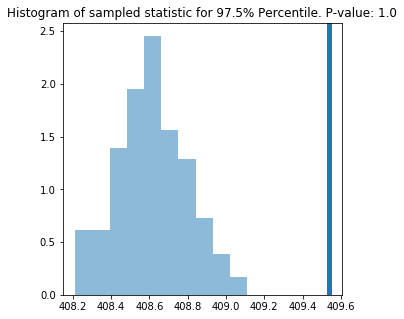

In [165]:
generate_test_histogram(np.array(test_percentile_high).flatten(), percentile_high(data.CO2.values), "97.5% Percentile")

In [151]:
test_percentile_low  = generate_test_statistics(percentile_low, generate_data_quad, final_samples)

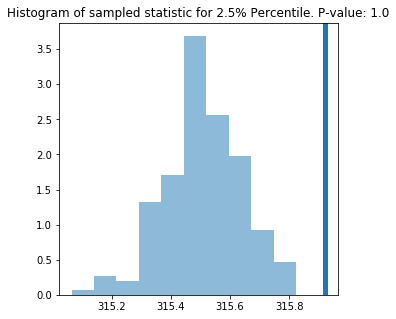

In [166]:
generate_test_histogram(np.array(test_percentile_low).flatten(), percentile_low(data.CO2.values), "2.5% Percentile")